In [249]:
import pandas as pd
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [250]:
# MIGHT HAVE TO CHANGE COLUMN NAMES - NOT SURE IF I HAVE THE CORRECT AMOUNT

def read_data(filename):

    df = pd.read_csv(filename, low_memory=False, header=None)
    df.columns = ["Timestamp", "LineID", "Direction", "JourneyPatternID", "TimeFrame",
                  "VehicleJourneyID", "Operator", "Congestion", "Lon", "Lat",
                  "Delay", "BlockID", "VehicleID", "StopID", "AtStop"]
    
    return df

In [251]:
# ADDING HOUR, DAY, HUMANTIME COLUMNS
# DROPPING IRRELEVANT COLUMNS
# CAN REMAIN UNCHANGED - MIGHT WANT TO MAKE HOUR MORE GRANULAR? 

def add_features(df):

    # Add column for human readable time
    df['HumanTime'] = pd.to_datetime(df['Timestamp'], unit='us')


    # Add day of week column
    df['Day'] = df['HumanTime'].dt.dayofweek

    # Add hour of day column
    df['Hour'] = df['HumanTime'].dt.hour


    # Dropping irrelevant columns
    for column in ['BlockID', 'Direction', 'Operator', 'Delay', 'Congestion']:
        df = df.drop(column, 1)
    
    return df

In [252]:
# REMOVE ALL JOURNEYS WHERE BUS DOESN'T START AT CORRECT STOP HERE
# FIND MOST COMMON STARTING STOP, DROP ALL JOURNEYS WHICH DON'T HAVE THIS
# AS THEIR FIRST STOP

def filter_direction(df):

    # converting data, adding compound feature
    for column in ['TimeFrame', 'VehicleJourneyID',]:
            df[column] = df[column].astype('str')

    df["JourneyGroup"] = df["TimeFrame"] + df["VehicleJourneyID"]


    patterns = df.JourneyPatternID.unique()

    tempdf = pd.DataFrame()

    for pattern in patterns:
        patterndf = df[df.JourneyPatternID == pattern]

        firstlines = patterndf.groupby(["TimeFrame", "VehicleJourneyID"]).head(1)
        start = firstlines.StopID.mode()[0]
        #     print(start)

        # Getting all journeys that start at the right stop
        valid_journeys = []
        for index, row in firstlines.iterrows():
            if row.StopID == start:
                valid_journeys.append(row.JourneyGroup)

        # removing journeys that don't start at the right stop
        patterndf = patterndf[patterndf.JourneyGroup.isin(valid_journeys)]


        if tempdf.empty:
            tempdf = patterndf

        else: 
            tempdf = pd.concat([tempdf, patterndf], axis=0)

    return tempdf

In [253]:
# DROPPING ROWS WHERE BUS ISN'T AT STOP 
# THIS SECTION NEEDS TO BE CHANGED, INCLUDE ONLY ROWS WHERE STOPID CHANGES

def drop_rows(df):

    # drop duplicate rows
    df = df.drop_duplicates(["TimeFrame", "VehicleJourneyID", "StopID"])

    # mean = df.JourneyGroup.value_counts().mean()
    # drop trips with less than 5 stops
    df = df[df.groupby('JourneyGroup').JourneyGroup.transform(len) > 5]
    
    return df

In [332]:
def runtime_function(row, mydict):
    # Takes a row and a dictionary of start times
    # returns time elapsed (seconds) between that row's timestamp and the start of the line
#     start = mydict[row.TimeFrame, row.VehicleID, row.VehicleJourneyID]["time"]
    start = mydict[row.TimeFrame, row.VehicleJourneyID]["time"]

    current = row.Timestamp
    return (current - start) // 1000000

In [333]:
# ADDING RUNTIME COLUMN - THIS CAN REMAIN UNCHANGED

def add_runtime(df):
    # Putting the first sightings of a vehiclejourneyid and timeframe combo timestamp into a dictionary
    start_times = {}
    
#     df = df.sort_values(['Timestamp'])

    # This gives you the first line anything has been seen by
#     firstlines = df.groupby(["TimeFrame", "VehicleID", "VehicleJourneyID"]).head(1)
    firstlines = df.groupby(["TimeFrame", "VehicleJourneyID"]).head(1)


#     firstlines = firstlines.sort_values(['Timestamp']).head(1)

    # This iterates through them and assigns values to the dictionary
    for index, row in firstlines.iterrows():
        start_times[row.TimeFrame, row.VehicleJourneyID] = {"time":row.Timestamp, "loc":[row.Lat, row.Lon]}

#         start_times[row.TimeFrame, row.VehicleID, row.VehicleJourneyID] = {"time":row.Timestamp, "loc":[row.Lat, row.Lon]}


    df['Runtime'] = ""

    # Applies this function to the newdf
    df['Runtime'] = df.apply(lambda row: runtime_function(row, start_times),axis=1)
    
    return df

In [334]:
def insert_into_file(df, writefile):
    """  This function writes a dataframe (df) to a file (writefile),
        or does nothing if the file doesn't exist
        
        CHANGED FROM OTHER
    """
    try:
        with open(writefile, 'a') as f:
#             df.to_csv(f, header=False, index=False)
            print(writefile, "exists")
            pass
    except IOError:
        with open(writefile, 'w+') as f:
            df.to_csv(f, header=False, index=False)


In [318]:
def main(read_directory, write_directory):
    for read_file in os.listdir(read_directory):
        if read_file.endswith(".csv"):
            if os.path.isfile(write_directory + "/" + read_file):
                print(read_file, "exists")
            else:
                print("Reading", read_file, "from", read_directory)
                try:
                    df = read_data(read_directory + "/" + read_file)
                    df = add_features(df)
                    df = filter_direction(df)
                    df = drop_rows(df)
                    df = add_runtime(df)

                    with open(write_directory + "/" + read_file, 'w+') as f:
                        df.to_csv(f, header=False, index=False)
                except (ValueError, IndexError) as error:
                    print(error, "!")
                    print("Couldn't finish", read_file)
                    

                print("Finished", read_file)
                print()
    print("Finished main!")

In [353]:
# MAIN SECTION

read_directory = "bus_data/line_data2"
write_directory = "bus_data/clean_data2"

main(read_directory, write_directory)

Reading 1.csv from bus_data/line_data2
Finished 1.csv

Reading 102.csv from bus_data/line_data2
Finished 102.csv

Reading 104.csv from bus_data/line_data2
Finished 104.csv

Reading 11.csv from bus_data/line_data2
Finished 11.csv

Reading 111.csv from bus_data/line_data2
Finished 111.csv

Reading 114.csv from bus_data/line_data2
Finished 114.csv

Reading 116.csv from bus_data/line_data2
Finished 116.csv

Reading 118.csv from bus_data/line_data2
Finished 118.csv

Reading 120.csv from bus_data/line_data2
Finished 120.csv

Reading 122.csv from bus_data/line_data2
Finished 122.csv

Reading 123.csv from bus_data/line_data2
Finished 123.csv

Reading 13.csv from bus_data/line_data2
Finished 13.csv

Reading 130.csv from bus_data/line_data2
Finished 130.csv

Reading 14.csv from bus_data/line_data2
Finished 14.csv

Reading 140.csv from bus_data/line_data2
Finished 140.csv

Reading 142.csv from bus_data/line_data2
Finished 142.csv

Reading 145.csv from bus_data/line_data2
Finished 145.csv

Reading

In [335]:
# readfile = "bus_data/line_data2/15.csv"

# df = read_data(readfile)
# df = add_features(df)
# df = filter_direction(df)
# df = drop_rows(df)
df = add_runtime(df)

In [336]:
df.head()

,Timestamp,LineID,JourneyPatternID,TimeFrame,VehicleJourneyID,Lon,Lat,VehicleID,StopID,AtStop,HumanTime,Day,Hour,JourneyGroup,Runtime
185,1352181603000000,15,1,2012-11-06,5891,-6.151784,53.402409,33553,6318,0,2012-11-06 06:00:03,1,6,2012-11-065891,0
190,1352181644000000,15,1,2012-11-06,5891,-6.153783,53.402687,33553,6319,1,2012-11-06 06:00:44,1,6,2012-11-065891,41
194,1352181683000000,15,1,2012-11-06,5891,-6.158463,53.402805,33553,7246,0,2012-11-06 06:01:23,1,6,2012-11-065891,80
202,1352181764000000,15,1,2012-11-06,5891,-6.162246,53.401226,33553,6320,0,2012-11-06 06:02:44,1,6,2012-11-065891,161
208,1352181825000000,15,1,2012-11-06,5891,-6.163521,53.399288,33553,4594,1,2012-11-06 06:03:45,1,6,2012-11-065891,222


In [337]:
out = df[df.JourneyPatternID == 1]

out = out.groupby(['StopID'])['Runtime'].mean().reset_index()

# out
# out.sort_values(['Runtime'])


In [338]:
journeys = df.JourneyGroup.unique()
journeys = journeys[:100]

In [339]:
negs = df[(df.Runtime < 0)]
negs.head(100)

,Timestamp,LineID,JourneyPatternID,TimeFrame,VehicleJourneyID,Lon,Lat,VehicleID,StopID,AtStop,HumanTime,Day,Hour,JourneyGroup,Runtime


In [340]:
# for index in journeys:
#     for i in range(1000):
#         first = df[df.JourneyGroup == index].head(1)
#     #     if first.Runtime < 0:
#     #         print(first[['HumanTime', 'Runtime']])
#         print(first[['JourneyGroup', 'Runtime']])

In [351]:
journey = df[df.JourneyGroup == "2012-11-065815"]
times = journey[['HumanTime', 'Runtime']]

# middle = journey[(journey.Runtime < 10000) & (times.Runtime > -1000)]

# middle

journey.tail()


,Timestamp,LineID,JourneyPatternID,TimeFrame,VehicleJourneyID,Lon,Lat,VehicleID,StopID,AtStop,HumanTime,Day,Hour,JourneyGroup,Runtime
36492,1352221135000000,15,1,2012-11-06,5815,-6.321288,53.278419,33469,4869,0,2012-11-06 16:58:55,1,16,2012-11-065815,5409
36642,1352221274000000,15,1,2012-11-06,5815,-6.330113,53.276764,33469,4870,1,2012-11-06 17:01:14,1,17,2012-11-065815,5548
36687,1352221313000000,15,1,2012-11-06,5815,-6.331184,53.276196,33469,3007,1,2012-11-06 17:01:53,1,17,2012-11-065815,5587
36753,1352221374000000,15,1,2012-11-06,5815,-6.330219,53.273067,33469,6283,0,2012-11-06 17:02:54,1,17,2012-11-065815,5648
37231,1352221839000000,15,1,2012-11-06,5815,-6.328600,53.271385,33469,6282,1,2012-11-06 17:10:39,1,17,2012-11-065815,6113


In [ ]:
# 6282

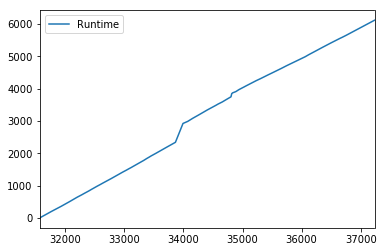

In [344]:
times.plot()

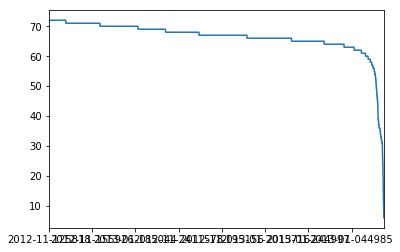

In [328]:
df.JourneyGroup.value_counts().plot()

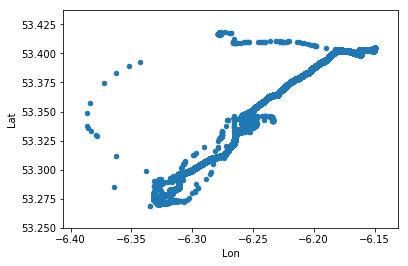

In [329]:
locations = newdf[["Lon", "Lat"]]
locations.plot.scatter(x="Lon", y="Lat")

In [330]:
newdf.JourneyGroup.unique()

array(['2012-11-065891', '2012-11-065899', '2012-11-065902', ...,
       '2013-01-317271', '2013-01-317278', '2013-01-317289'], dtype=object)

In [331]:
xxxx = df[df.JourneyGroup == "2013-01-085057"]
xxxx.shape

(71, 15)

In [ ]:
firstlines = patterndf.groupby(["TimeFrame", "VehicleJourneyID"]).head(1)



In [ ]:
# ADDING RUNTIME COLUMN - THIS CAN REMAIN UNCHANGED

# # Putting the first sightings of a vehiclejourneyid and timeframe combo timestamp into a dictionary
# start_times = {}

# # This gives you the first line anything has been seen by
# firstlines = df.groupby(["TimeFrame", "VehicleJourneyID"]).head(1)

# # This iterates through them and assigns values to the dictionary
# for index, row in firstlines.iterrows():
#     start_times[row.TimeFrame, row.VehicleJourneyID] = {"time":row.Timestamp, "loc":[row.Lat, row.Lon]}


# df['Runtime'] = ""

# # Applies this function to the newdf
# df['Runtime'] = df.apply(lambda row: add_runtime(row, start_times),axis=1)